# Cross Validation Notebook Example

## Underlying function

Smooth function we're trying to replicate:
$$
y_{\rm smooth}(x) = {\rm e}^{-x^2}
$$

Smooth data with oscillations:
$$
y_{\rm smooth\, osc.}(x) = \left(\frac{x}{10 a} \right) \sin(a\pi x)
$$

Then add Gaussian random noise $\eta(x) = \mathcal{N}(0, \sigma)$ with $\langle \eta(x)\eta(x^\prime) \rangle = \sigma^2 \delta(x - x^\prime)$.

So the final form is 
$$
y(x) = y_{\rm smooth}(x) + y_{\rm smooth\, osc.}(x) + \eta(x).
$$

In [191]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.interpolate as interp

def smooth_curve(x_values):
    return np.exp( -x_values**2 )

def smooth_but_osc(x_values, freq = 1.):
    return (x_values / (15*freq)) * np.sin(freq * np.pi * x_values)

def gaussian_white_noise( x_values, sigma=1. ):
    return np.random.normal(0., scale=sigma, size=x_values.shape)

def final_data(x_values, freq=1., sigma=1.):
    return smooth_curve(x_values) + smooth_but_osc(x_values, freq=freq) + gaussian_white_noise(x_values, sigma=sigma)

def plot_data_and_smooth_curve(axis, xdata, ydata):
    axis.plot(xdata, ydata, "o", ls="None", label="Data", alpha=0.35)
    axis.plot(xdata, smooth_curve(xdata), color="red", ls="dashed", lw=3, label="Underlying Curve")
    return axis

In [192]:
x_values = np.linspace(-5, 5, 1000)
y_values = final_data(x_values, freq=1, sigma = 0.3)

In [193]:
spline_data_tck = interp.splrep(x_values,y_values, s=100)
spline_data_eval = interp.splev(x_values,spline_data_tck)

<IPython.core.display.Javascript object>


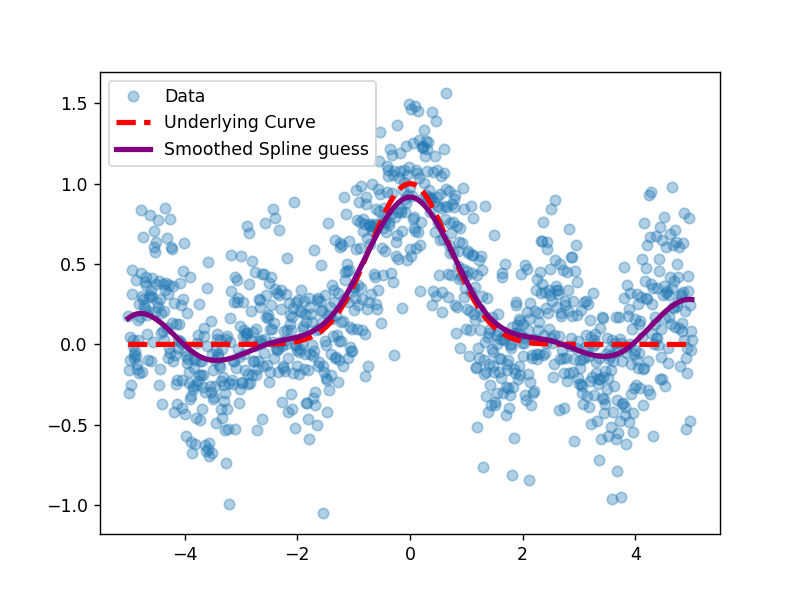

In [194]:
%matplotlib notebook
fig, axis = plt.subplots(1,1)
plot_data_and_smooth_curve(axis, x_values, y_values)
axis.plot(x_values, spline_data_eval, lw=3, color = 'purple', label="Smoothed Spline guess")
axis.legend()
plt.show()

## Cross-Validation Steps

1. Bin data and then randomly sample _training data_. All data not in the training data are _test data_.
1. Sweep smoothness parameters of spline fits to training data.
1. Optimize spline smoothness on the test data to yield the fit.
1. Repeat with new training set if necessary.

### Step 1: Bin data into _training_ and _test_ sets

In [195]:
def bin_x_values(x_values, nbins=10):
    # Return an array of index values 
    # representing the start of each 
    # equally-spaced bin.
    return np.arange(0, len(x_values), len(x_values)//nbins)[0:nbins]

def sample_from_bins(x_values, nbins=10, samples_per_bin=1):
    # Return indices of binned and sampled
    # data taken without replacement from x and y
    start_indices = bin_x_values(x_values, nbins=nbins)
    sample_indices = []
    for idx in range(0, len(start_indices)):
        bin_start = start_indices[idx]
        bin_end = len(x_values)
        if idx < len(start_indices) - 1:
            bin_end = start_indices[idx + 1]
        indices = np.random.choice( np.arange(bin_start, bin_end), replace=False, size=samples_per_bin )
        if indices.shape == ():
            sample_indices.append(indices)
        else:
            for index in indices:
                sample_indices.append(index)
    sample_indices.sort()
    sample_indices = np.array(sample_indices)
    return np.array(sample_indices, dtype=int)

def separate_train_and_test_indices(x_values, nbins=10, samples_per_bin=1):
    # Collect the training indices and then 
    # separate the test indices from it.
    training_indices = sample_from_bins(x_values, nbins=nbins, samples_per_bin=samples_per_bin)
    all_indices = np.arange(0, len(x_values))
    test_indices = np.array([], dtype=int)
    for index in all_indices:
        if index not in training_indices:
            test_indices = np.append(test_indices, index)
    return training_indices, test_indices

def separate_training_and_testing_data(x_values, y_values, nbins=10, samples_per_bin=1):
    training_indices, test_indices = separate_train_and_test_indices(x_values, nbins=nbins, samples_per_bin=samples_per_bin)
    training_set = np.zeros((2, len(training_indices)))
    test_set = np.zeros((2, len(test_indices)))
    
    training_set[0,:] = x_values[training_indices]
    training_set[1,:] = y_values[training_indices]
    
    test_set[0,:] = x_values[test_indices]
    test_set[1,:] = y_values[test_indices]
    
    return training_set, test_set


In [208]:
nbins, samples_per_bin = 100, 1
train, test = separate_training_and_testing_data(x_values, y_values, nbins, samples_per_bin)

<IPython.core.display.Javascript object>


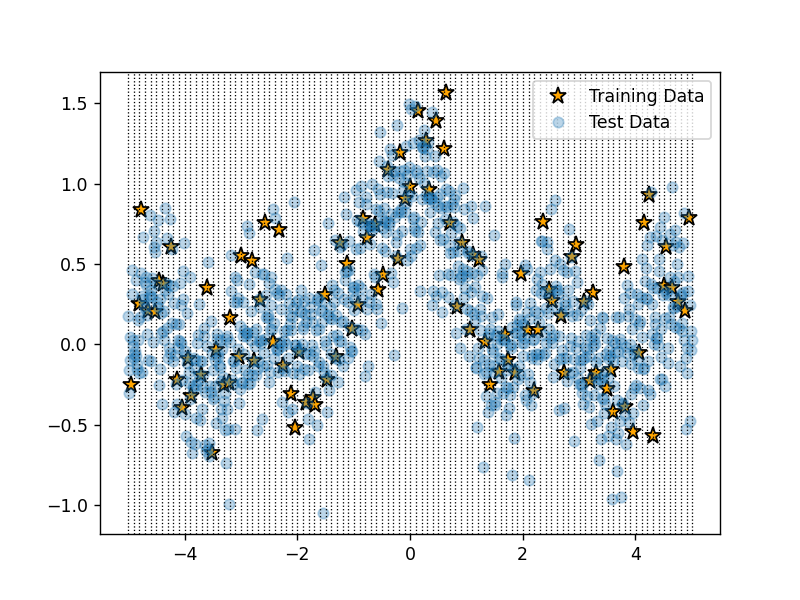

In [209]:
fig, axis = plt.subplots(1,1)
axis.plot(train[0,:], train[1,:], "*", ls="None", color = "orange", mec="black", ms=10, label="Training Data")
test_dots, = axis.plot(test[0,:], test[1,:], "o", ls="None", alpha=0.3, label="Test Data")
bindices = bin_x_values(x_values, nbins)
for idx in bindices:
    axis.axvline(x_values[idx], color="k", ls="dotted", lw=0.75)
axis.axvline(x_values[-1], color="k", ls="dotted", lw=0.75)
axis.legend()
plt.show()

### Step 2: Sweep smoothness parameters of spline fits to _training set_

In [220]:
def uniform_rand(a, b):
    return a + (b - a) * np.random.rand()

def choose_smoothing_parameters( max_smoothing_param, n_curves, lowest_power10 = -10 ):
    smooth_powers10 = np.zeros(n_curves)
    decades = np.linspace(lowest_power10, np.log10(max_smoothing_param), n_curves + 1)
    for idx in range(0, n_curves):
        smooth_powers10[idx] = uniform_rand( decades[idx], decades[idx + 1] )
        
    return np.power( 10, smooth_powers10 )
#     return  np.logspace( lowest_power10, np.log10(max_smoothing_param), n_curves)

def smoothing_splines(train_data_x, train_data_y, max_smoothing_param,n_curves=100):
    spline_data_tck_list = []
    smoothing_parameters = choose_smoothing_parameters( max_smoothing_param, n_curves )
    for smooth in smoothing_parameters:
        params = interp.splrep(train_data_x, train_data_y, s=smooth)
        spline_data_tck_list.append(params)
    return spline_data_tck_list, smoothing_parameters

def plot_splines(x_data, spline_tck, smooth_arr, axis):
#     print(len(spline_tck))
    for i in range(0,len(spline_tck)):
        y_data = interp.splev(x_data,spline_tck[i])
        if i % 4 == 0:
            axis.plot(x_data, y_data, ls="-", label=smooth_arr[i])
        else:
            axis.plot(x_data, y_data, ls="-")
    return axis
    

C:\Users\freed\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:509: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


<IPython.core.display.Javascript object>


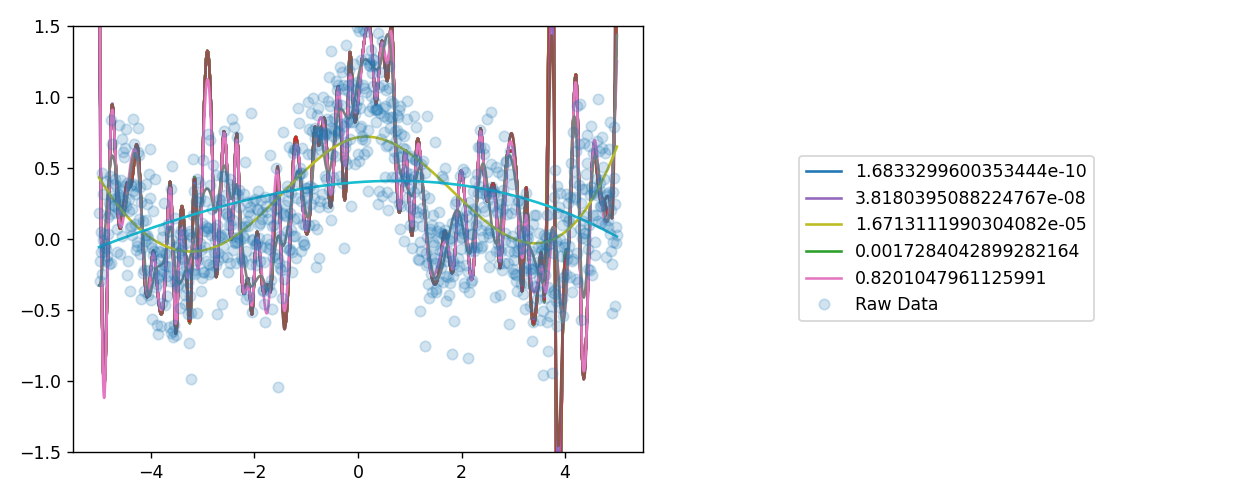

In [221]:
tck_vals, smooth_params = smoothing_splines(train[0,:],train[1,:],100,20)

fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0] = plot_splines(test[0,:],tck_vals, smooth_params, axes[0])
axes[0].plot(x_values, y_values, "o", color=test_dots.get_color(), ls="None", alpha=0.2, label="Raw Data")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].set_ylim(-1.5,1.5)

axes[1].set_axis_off()
axes[1].legend(handles, labels, loc='center')
fig.tight_layout()
plt.show()


## Step 3: Find Best Smoothing Spine

In [212]:
def find_RMSE(x_test, y_test, tck_params):
    y_spline = interp.splev(x_test,tck_params)
    
    RMSE = np.std( y_spline - y_test )
    
    return RMSE

def find_best_smooth(x_test,y_test, tck_params, smooth_arr):
    RMSE_arr = []
    for i in range(0, len(tck_params)):
        RMSE_arr.append(find_RMSE(x_test, y_test, tck_params[i]))
    return RMSE_arr
        

In [213]:
idx = np.argmin(find_best_smooth(test[0,:], test[1,:],tck_vals,smooth_params))
# print(smooth_params[idx])

## Step 4: Repeat _ad nauseum_

In [214]:
def find_best_spline(raw_data_x_run, raw_data_y_run, max_smooth_run, bin_number_run=10, samples_per_bin_run =1, n_smooths_run = 1000):
    # find training and testing data by first separating the data into even bins
    # then, randomly pick n samples per bin to be the testing data and generate
    # a test array and a train array.
    train_data_run, test_data_run = separate_training_and_testing_data(raw_data_x_run, raw_data_y_run, nbins=bin_number_run, samples_per_bin=samples_per_bin_run)
    
    # find the spline coefficients for each smoothing parameter in the training data
    tck_list_run, smooth_params_run = smoothing_splines(train_data_run[0,:], train_data_run[1,:], max_smooth_run, n_curves=n_smooths_run)
    
    # generate a list of RMSE values using the spline information from the test set
    RMSEs_run = find_best_smooth(test_data_run[0,:],test_data_run[1,:], tck_list_run, smooth_params_run)
    
    # find the index where the RMSE is the lowest (aka the best smoothing spline)
    idx_run = np.argmin(RMSEs_run)
    
    smooth_run = smooth_params_run[idx_run]
    RMSE_run = RMSEs_run[idx_run]
    tck_run = tck_list_run[idx_run]
     
    return smooth_run, RMSE_run, tck_run

In [215]:
def iterate_over_training_set(training_sets, raw_data_x_iter, raw_data_y_iter, max_smooth_iter, bin_number_iter=10, samples_per_bin_iter =1, n_smooths_iter = 1000):
    
    smooth_iter_arr = []
    RMSE_iter_arr = []
    tck_iter_arr = []
    
    for iter in range(0, training_sets):
        smooth_output_iter, RMSE_output_iter, tck_output_iter = find_best_spline(raw_data_x_iter, raw_data_y_iter, max_smooth_iter, bin_number_iter, samples_per_bin_iter, n_smooths_iter)
        
        smooth_iter_arr.append(smooth_output_iter)
        RMSE_iter_arr.append(RMSE_output_iter)
        tck_iter_arr.append(tck_output_iter)
        
    return smooth_iter_arr, np.array(RMSE_iter_arr), tck_iter_arr
    

In [216]:
num_train = 80
smoothers, RMSErs, tckers = iterate_over_training_set(num_train,x_values, y_values, 10, 10, 1, 1000)

C:\Users\freed\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:509: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


0.7345963221002472
0.38107813646108624


<IPython.core.display.Javascript object>


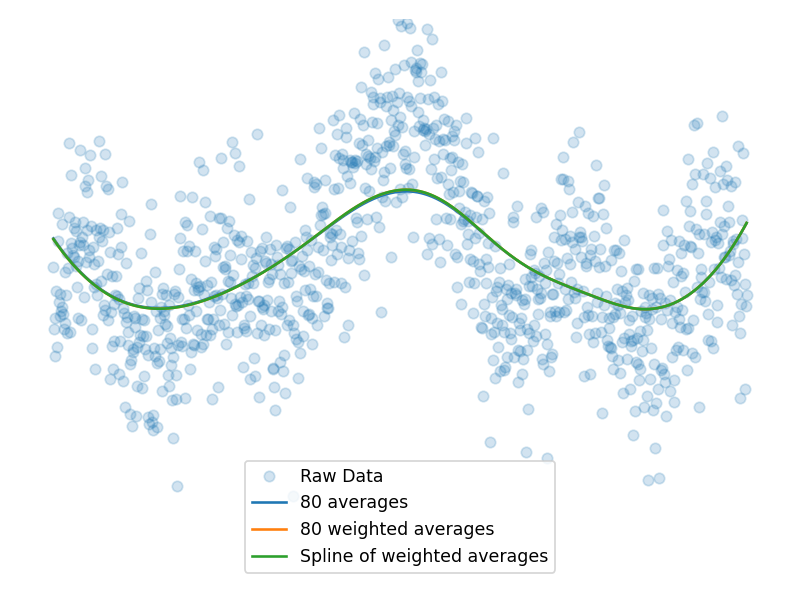

In [217]:
smooth_output, RMSE_output, tck_output = find_best_spline(x_values, y_values, 10, 10, 1, 1000)

print(smooth_output)
print(RMSE_output)

output_avg = np.zeros(len(x_values))
output_avg_weighted = np.zeros(len(x_values))



fig_final, axes_final = plt.subplots(1,1)


axes_final.plot(x_values, y_values, "o", color=test_dots.get_color(), ls="None", alpha=0.2, label="Raw Data")

partition_function = np.sum( 1. / RMSErs )
for i in range(0, num_train):
    y_good_spline = interp.splev(x_values,tckers[i])
#     axes_final.plot(x_values, y_good_spline, ls="-", label=smoothers[i])
    weight = 1/num_train
    output_avg += weight * y_good_spline
    weight = (1/RMSErs[i]) / partition_function
    output_avg_weighted += weight * y_good_spline



final_tck = interp.splrep( x_values, output_avg_weighted, s=0. )
final_spl_output = interp.splev( x_values, final_tck )
axes_final.plot(x_values, output_avg, ls="-", label=str(num_train)+" averages")
axes_final.plot(x_values, output_avg_weighted, ls="-", label=str(num_train)+" weighted averages")
axes_final.plot(x_values, final_spl_output, ls="-", label="Spline of weighted averages")
handles, labels = axes_final.get_legend_handles_labels()
axes_final.set_ylim(-1.5,1.5)

axes_final.set_axis_off()
axes_final.legend(handles, labels, loc='best')
fig_final.tight_layout()
plt.show()

